# Train With Colbert

In [4]:
import os
import glob
import polars as pl
import polars.selectors as cs
import pandas as pd
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from dataclasses import dataclass
from typing import Optional, Union
from scipy.special import softmax
from pathlib import Path

from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries
from colbert import Indexer, Searcher

import wandb
import torch
import evaluate
from transformers import AutoTokenizer, AutoModelForMultipleChoice, Trainer, TrainingArguments, IntervalStrategy, get_linear_schedule_with_warmup
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from datasets import Dataset # HuggingFace
from torch.optim import AdamW

In [5]:
pl.Config(fmt_str_lengths=2000);

In [6]:
#!conda install -c conda-forge faiss-gpu -y

In [7]:
dfs = []
folder_path = './data/daniel_train/aug_30/*'
columns = ['question', 'correct', 'incorrect_1', 'incorrect_2', 'incorrect_3', 'incorrect_4', 'title', 'section_title']

for csv_file in glob.glob(folder_path):
    df = pl.read_csv(csv_file)
    dfs.append(df[columns])

train_raw = pl.concat(dfs)
train_raw.shape

(2150, 8)

In [8]:
choices_np = train_raw[['correct', 'incorrect_1', 'incorrect_2', 'incorrect_3', 'incorrect_4']].to_numpy()

n_rows, n_cols = choices_np.shape
shuffled_indices = np.array([np.random.permutation(n_cols) for _ in range(n_rows)])
shuffled_data = np.take_along_axis(choices_np, shuffled_indices, axis=1)
correct_positions = np.argmax(shuffled_data == choices_np[:, 0][:, np.newaxis], axis=1)

answer_map = np.array(['A', 'B', 'C', 'D', 'E'])
answers = answer_map[correct_positions]

choices = pl.DataFrame({
    'A': shuffled_data[:, 0].astype(str),
    'B': shuffled_data[:, 1].astype(str),
    'C': shuffled_data[:, 2].astype(str),
    'D': shuffled_data[:, 3].astype(str),
    'E': shuffled_data[:, 4].astype(str),
    'answer': answers
    },
    [(col, pl.Utf8) for col in ['A', 'B', 'C', 'D', 'E', 'answer']]
)

train = train_raw[['question','title', 'section_title']].with_columns(choices)
train.columns

['question', 'title', 'section_title', 'A', 'B', 'C', 'D', 'E', 'answer']

In [9]:
test = pl.read_csv('data/train.csv')
test = test.rename({'prompt': 'question'})
test = test.drop(columns="id")
test.columns

['question', 'A', 'B', 'C', 'D', 'E', 'answer']

## Retrieve Wiki Context via ColBERT

In [10]:
max_words = 200
wiki_passages = pl.read_parquet('./data/wiki_passages_{max_words}.parquet')
wiki_passages.columns

['passage_id', 'section_id', 'title', 'section_title', 'passage_text']

In [11]:
n_results_per_question = 1

nbits = 2   # encode each dimension with 2 bits
doc_maxlen = 512   # lenght in tokens
dim = 128 # 128 is max for BERT

checkpoint = './checkpoints/colbertv2.0'
experiment = 'wiki-science'
indexer_name = f"wiki_pages_index_{nbits}bits"
#os.environ['COLBERT_LOAD_TORCH_EXTENSION_VERBOSE'] = 'True'

config = ColBERTConfig(
    doc_maxlen=doc_maxlen,
    nbits=nbits,
    dim=dim
)

In [12]:
def add_wiki_context(data):
    queries = data.with_row_count('qid')[['qid', 'question']]
    queries = queries.with_columns(pl.col('question').str.replace_all('\n', ' ')) 
    queries_file = './data/wiki_queries.tsv'
    queries.write_csv(queries_file, separator='\t', has_header=False)

    c_queries = Queries(queries_file)

    with Run().context(RunConfig(nranks=1, experiment=experiment)):
        searcher = Searcher(index=indexer_name, config=config)
        ranking = searcher.search_all(c_queries, k=n_results_per_question)

    colbert_passage_ids = pl.Series([tup[1] for tup in ranking.flat_ranking], dtype=pl.UInt32)
    data_p = data.with_columns(passage_id=colbert_passage_ids)
    return data_p.join(wiki_passages[['passage_id', 'section_text']], how='left', on='passage_id')

In [13]:
train_p_path = Path('./data/train_daniel_with_wiki_context.parquet')
test_p_path = Path('./data/test_daniel_with_wiki_context.parquet')

if train_p_path.exists():
    train_p = pl.read_parquet(train_p_path)
else:
    train_p = add_wiki_context(train)
    torch.cuda.empty_cache()
    train_p.write_parquet(train_p_path)
    
    
if test_p_path.exists():
    test_p = pl.read_parquet(test_p_path)
else:
    test_p = add_wiki_context(test)
    torch.cuda.empty_cache()
    test_p.write_parquet(test_p_path)

## Prepare Train and Test for DeBERTa

In [14]:
deberta_v3_large = 'microsoft/deberta-v3-large'
tokenizer = AutoTokenizer.from_pretrained(deberta_v3_large)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
max_length = 600

option_to_index = {option: idx for idx, option in enumerate('ABCDE')}
index_to_option = {v: k for k,v in option_to_index.items()}

def preprocess(example):
    # adding the wikipedia page as context for the question by adding it after a [SEP] token to the question.
    first_sentence = [f"{example['question']} [SEP] {example['section_text']}"] * 5
    second_sentences = [example[option] for option in 'ABCDE']
    tokenized_example = tokenizer(first_sentence, second_sentences, truncation='only_first', max_length=max_length)
    tokenized_example['label'] = option_to_index[example['answer']]
    
    return tokenized_example

@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None

    
    def __call__(self, input_batch):
        # input_batch is list of samples, choices, tokens
        additional_cols = set(input_batch[0].keys()) - set(['input_ids', 'token_type_ids', 'attention_mask', 'label'])
        if len(additional_cols) > 0:
            print(f'{additional_cols=}')
        
        label_name = 'label' if 'label' in input_batch[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in input_batch]
        batch_size = len(input_batch)
        num_choices = len(input_batch[0]['input_ids'])
        flattened_input = [
            [{k: v[i] for k, v in sample.items()} for i in range(num_choices)] for sample in input_batch
        ]
        flattened_input = sum(flattened_input, [])
        
        batch = self.tokenizer.pad(
            flattened_input,
            padding=self.padding,
            max_length=self.max_length,
            return_tensors='pt',
        )
        
        # batch.shape = (n_samples, n_choices, n_tokens)
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        #print(np.array(batch['input_ids']).shape)
        return batch

In [16]:
train_dataset = Dataset.from_pandas(train_p.to_pandas(), preserve_index=False)
tokenized_columns = ['question', 'A', 'B', 'C', 'D', 'E', 'answer']
metadata_columns = ['title', 'section_text', 'section_title', 'passage_id']
tokenized_train = train_dataset.map(preprocess, remove_columns=tokenized_columns+metadata_columns)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

<Axes: >

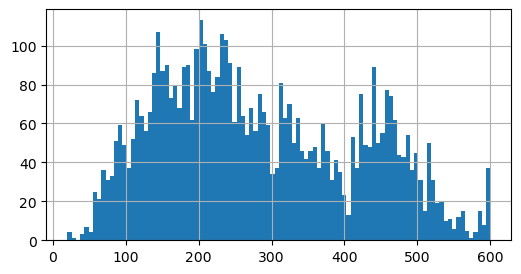

In [17]:
length_list = []
for sample in tokenized_train['input_ids']:
    for option in sample:
        length_list.append(len(option))

plt.figure(figsize=[6,3])
pd.Series(length_list).hist(bins=100)

In [18]:
test_dataset = Dataset.from_pandas(test_p.to_pandas())
tokenized_test = test_dataset.map(preprocess, remove_columns=['question', 'A', 'B', 'C', 'D', 'E', 'answer'])
tokenized_test

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['passage_id', 'section_text', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 200
})

## Train DeBERTa

In [19]:
def precision_at_k(predictions, actuals, k=3):        
    if isinstance(actuals, list):
        actuals = np.array(actuals)
        
    found_at = np.where(predictions == actuals.reshape(-1, 1))
    # found_at is a tuple with the array of found indices in the second position
    score = 1 / (1 + found_at[1])
    score[score < 1/k] = 0
    return score

def mean_avg_precision_at_k(predictions, actual, k=3):
    n = predictions.shape[0]
    row_precision = precision_at_k(predictions, actual)
    return row_precision.sum()/n

acc_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.flip(predictions.argsort(axis=1), axis=1)
    accuracy = acc_metric.compute(predictions=predictions[:,0], references=labels)['accuracy']
    map_at_3 = mean_avg_precision_at_k(predictions, labels)
    return {
        'accuracy': accuracy,
        'map_at_3': round(map_at_3, 3)
    }

In [20]:
#AutoModelForMultipleChoice.from_pretrained(deberta_v3_large)

In [21]:
retrain = True

output_path = Path('./checkpoints')
training_args = TrainingArguments(
    learning_rate=5e-6,
    num_train_epochs=6,
    #fp16=True,
    warmup_ratio=0.5,
    weight_decay=0.002,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=16,
    evaluation_strategy = IntervalStrategy.STEPS,
    logging_steps=100,
    eval_steps=500,
    save_steps=5000,
    report_to='wandb',
    output_dir=str(output_path),
    run_name='Train with Colbert'
)

if not output_path.exists() or retrain:
    model = AutoModelForMultipleChoice.from_pretrained(deberta_v3_large)
    
    # embedding_lr = 1e-8
    # early_layers_lr = 1e-7
    # middle_layers_lr = 1e-6
    # late_layers_lr = 2e-5
    # classifier_lr = 5e-5

#     optimizer_grouped_parameters = [
#         {'params': model.deberta.embeddings.parameters(), 'lr': embedding_lr},
#         {'params': model.deberta.encoder.layer[:8].parameters(), 'lr': early_layers_lr},
#         {'params': model.deberta.encoder.layer[8:16].parameters(), 'lr': middle_layers_lr},
#         {'params': model.deberta.encoder.layer[16:].parameters(), 'lr': late_layers_lr},
#         {'params': model.classifier.parameters(), 'lr': classifier_lr},
#     ]
    optimizer = AdamW(model.parameters(),
                      lr=training_args.learning_rate,
                      weight_decay=training_args.weight_decay)
                      #optimizer_grouped_parameters)
    
    total_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
    warmup_steps = int(total_steps * training_args.warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer, max_length=600),
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        optimizers=(optimizer, scheduler)
    )
    

    trainer.train()
    wandb.finish()
else:
    model = AutoModelForMultipleChoice.from_pretrained(output_path/'checkpoint-19500')

Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: datadan. Use `wandb login --relogin` to force relogin


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Map At 3
500,1.602100,1.608639,0.355000,0.478000
1000,1.200300,1.308999,0.535000,0.643000
1500,0.801000,1.115933,0.630000,0.722000
2000,0.954400,0.948591,0.690000,0.788000
2500,0.556300,0.963374,0.720000,0.812000
3000,0.558700,1.072957,0.695000,0.798000
3500,0.302500,0.890864,0.695000,0.804000
4000,0.443600,0.962828,0.700000,0.794000
4500,0.184500,0.911541,0.685000,0.790000
5000,0.162900,1.030687,0.710000,0.808000


/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁▄▆▇█▇▇█▇███
eval/loss,█▅▃▂▂▃▁▂▁▂▃▂
eval/map_at_3,▁▄▆▇████████
eval/runtime,█▂▂▂▂▁▂▂▁▂▁▂
eval/samples_per_second,▁▇▇▇▇█▇▇█▇█▇
eval/steps_per_second,▁▆▇▆▆█▇▇▇▇▇▆
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇████▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▁▁
train/loss,██████▆▄▅▅▅▆▅▅▃▃▃▃▂▄▂▂▂▂▂▂▃▂▁▁▂▂▂▂▁▁▁▁▁▁
train/total_flos,▁
